# Sanity check

In this note book we will do some sanity check with Boyd's and Argwal's textbooks to make sure our simulation is correct.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### SHG

By Boyd's textbook Equation (2.7.43), the SHG efficiency should be `(length/nlLength)**2` for small pump (or large `nlLength`), so we can use this equation as a sanity check.

In [2]:
def SHG_efficiency(beta21 = 0, beta22 = 0, dbeta0 = 0, length = 1, nlLength = 1e1, 
                   tMax = 15, tPrecision = 2**10, zPrecision = 2000):
    """
    Calculate the SHG efficiency
    
    Arguments:
    beta21:      second order dispersion of pump, set to 1 since we are working in unit of dispersion length
    beta22:      second order dispersion of second harmonic
    dbeta0:      phase mismatch

    length:      length of crystal, in unit of dispersion length
    nlLength:    nonlinear length
    
    tMax:        pulse width
    tPrecision:  precision of time axis
    zPrecision:  precision of position axis
    
    Return: SHG efficiency
    
    """
    
    # Initialize time and position axes
    tau   = (2 * tMax / tPrecision) * np.arange(-tPrecision / 2, tPrecision / 2)
    omega = (-np.pi / tMax) * np.arange(-tPrecision / 2, tPrecision / 2)
    dz = length / zPrecision

    # Initialize fields
    pumpTemp = 1/np.cosh(tau)**2
    signalTemp = pumpTemp * 0
    
    u1 = pumpTemp.copy()
    u2 = signalTemp.copy()
    total_energy = np.sum(np.abs(pumpTemp)**2)

    # Dispersion operator
    linear_operator1 = np.fft.fftshift(np.exp(0.5j * beta21 * omega**2 * dz))
    linear_operator2 = np.fft.fftshift(np.exp(0.5j * beta22 * omega**2 * dz))
  
    # Propagation loop
    for i in range(zPrecision):
        # Linear step (Fourier domain)
        u1_hat = np.fft.fft(u1) * linear_operator1
        u2_hat = np.fft.fft(u2) * linear_operator2
        u1 = np.fft.ifft(u1_hat)
        u2 = np.fft.ifft(u2_hat)

        # Nonlinear step (Time domain)
        u1 += dz * (1j / nlLength) * np.conjugate(u1) * u2 * np.exp(-1j * dbeta0 * dz * i)
        u2 += dz * (1j / nlLength) * u1**2 * np.exp(1j * dbeta0 * dz * i)

    # Calculate efficiency
    eff  = np.sum(np.abs(u2)**2) / total_energy
    
    return eff

In [3]:
# Here we are dealing with pump simulation so we need to add a correction factor,
# For sech^2 pulses this factor is derived in https://doi.org/10.1364/OL.22.000013
sech_factor = 0.668

# List of nonlinear lenth
nlLengthList   = np.arange(2,10, 0.5)

# Calculate simulation and theoretical efficiencies
eff_simulation = np.array([SHG_efficiency(nlLength=nl) for nl in nlLengthList])
eff_theory     = np.array([(1/nl)**2*sech_factor for nl in nlLengthList])

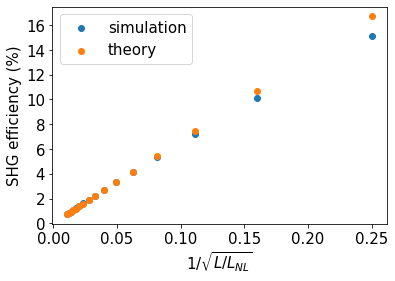

In [4]:
# Plot the simulation efficiency v.s. theoretical efficiency

plt.scatter(1/(nlLengthList)**2, eff_simulation*100, label = "simulation")
plt.scatter(1/(nlLengthList)**2, eff_theory*100, label = "theory")

plt.ylabel("SHG efficiency (%)", fontsize=15)
plt.xlabel("$1/\sqrt{L/L_{NL}}$", fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.legend(fontsize=15);

We can see the simulation and theory fit very well below 10% efficiency, a property also reported in Figure 3 of https://doi.org/10.1364/OL.22.000013. Above 10% the theory fails because of the low pump power assumption.

<img style="float:left;margin:0 10px 10px 0" src="https://d3i71xaburhd42.cloudfront.net/d85b8ad747618affd0329e97b5d0fb028b1bb0c3/3-Figure3-1.png" width="400"/>


### Kerr

The sanity check for Kerr nonlinearity is rather simple: We can simply check that we can get the fundamental soliton (Argwal's textbook)

In [5]:
from CascadeNL import Kerr

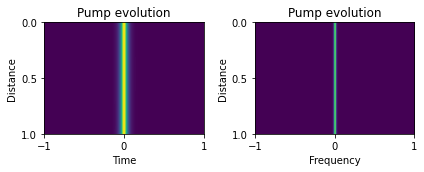

In [6]:
Kerr(beta2 = -1, gamma = 1, length = 10, tMax = 36, tPrecision = 2**11, zPrecision = 2000)